In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as functional
import sys 
#sys.path.append("../")
#import test_cuda
device = 'cpu' #test_cuda.device
from create_char import *
import matplotlib.pyplot as plt

device = cpu


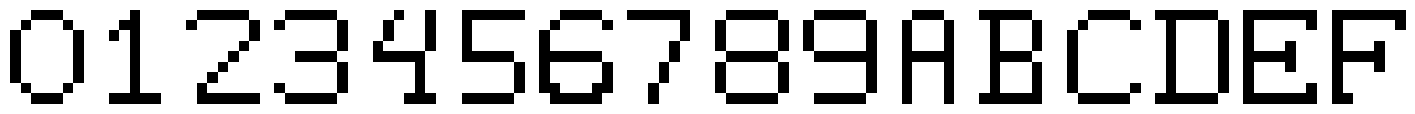

In [2]:
# Normal characters
P =  createChar()
showChar(P)

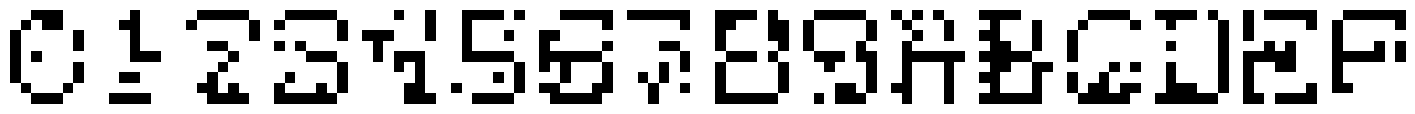

In [3]:
# Characters with 10% noise
Pn = char_noise(P,10)
showChar(Pn)

In [4]:
class MLP(nn.Module):
    """
    NN with two layers using tanh as activation function
    """
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=63, out_features=50)
        self.layer_2 = nn.Linear(in_features=50, out_features=16)
        self.tanh = nn.Tanh() 

    def forward(self, x):
       return self.layer_2(self.tanh(self.layer_1(x)))

# Loss function: mean squared error 
loss_fn = nn.MSELoss()

# Calculate the accuracy given the true and predicted values
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [5]:
# Each element of this list is one configuration of training the data containg the number of samples
# and the noise level
config_samples_noise = [
    [[16,0]],   #RNA0
    [[16,0],[16,10],], #RNA1
    [[16,0],[16,10],[16,20]],  #RNA2
    [[16,0],[16,10],[16,20],[16,30]],   #RNA3
    [[16,0],[16,10],[16,20],[16,30],[16,40],],   #RNA4
    [[16,0],[16,10],[16,20],[16,30],[16,40],[16,50],],   #RNA5
]

# This list contains number of seeds for each configuration of the training data 
list_seeds = [1,10,30]


# Dictionary that contains the neural networks and other informations
nns = {}


y_labels = np.arange(0,16).reshape(16,1)


for nn_num,config in enumerate(config_samples_noise):
    print(f"\n\n\{'=*'*15} {f'RNA{nn_num}'} {'=*'*15}")
    nns[nn_num] = {}
    for num_seeds in list_seeds:
        is_train_over =  False
        print(f"{'=*'*10} {f'Number of seeds = {num_seeds}'} {'=*'*10}")
        nns[nn_num][num_seeds] = {}

        # Define seed so all 6 nns have the same initial condition
        torch.manual_seed(num_seeds)

        # Insert nn and optimizer in the dictionary
        nns[nn_num][num_seeds]['mlp'] = MLP().to(device)
        nns[nn_num][num_seeds]['optimizer'] = torch.optim.SGD(params=nns[nn_num][num_seeds]['mlp'].parameters(), lr=0.7,momentum=0.0)
        
        ####################### Start creation of the training data #######################
        X_train = []
        X_test = []
        Y_train = []
        Y_test = []
        var=  0
        for samples, noise in config:
            for seed in range(num_seeds):    
                np.random.seed(seed)
                rng = np.random.default_rng(seed=seed)
                chosen_numbers =  rng.choice(16, samples,replace=False)
                x_train = char_noise(createChar().reshape((16,63)),noise)[chosen_numbers]
                x_test = char_noise(createChar().reshape((16,63)),noise)[chosen_numbers]
                X_train.append(x_train)
                X_test.append(x_test)
                y = y_labels.reshape(samples,1)[chosen_numbers]
                Y_train.append(y)
                Y_test.append(y)
            
        X_train = torch.from_numpy(np.concatenate(X_train,axis=0)).type(torch.float32).to(device)
        X_test = torch.from_numpy(np.concatenate(X_test,axis=0)).type(torch.float32).to(device)
        Y_train  = torch.from_numpy(np.concatenate(Y_train,axis=0)).squeeze().long().to(device)
        Y_test  = torch.from_numpy(np.concatenate(Y_test,axis=0)).squeeze().long().to(device)
        Y_train_oh = functional.one_hot(Y_train.squeeze()).type(torch.float32).to(device)
        Y_test_oh = functional.one_hot(Y_test.squeeze()).type(torch.float32).to(device)
        
        ####################### End creation of the training data #######################


        # Select the current nn and its optimizer. 
        # They could be accessed through the dictionary it would be too verbose
        mlp = nns[nn_num][num_seeds]['mlp']
        optimizer = nns[nn_num][num_seeds]['optimizer']

        # Number of epochs
        epochs = 1000


        # Arrays containg the history of:
        # Train accuracy
        train_acc_history = torch.zeros(epochs,dtype=torch.float32)
        # Train loss
        train_loss_history = torch.zeros(epochs,dtype=torch.float32)
        # Test accuracy
        test_acc_history = torch.zeros(epochs,dtype=torch.float32)

        ############################################ Start training ############################################
        for epoch in range(epochs):
            # Make sure gradient tracking is on, and do a pass over the data
            mlp.train()

            # Output of the nn 
            output = mlp(X_train)

            # Convert output into prediction 
            y_pred = torch.argmax(output,dim=1)
            
            # Calculate loss
            loss = loss_fn(output, 
                        Y_train_oh)

            # Save current loss in the array
            train_loss_history[epoch] = loss

            # Calculate accuracy
            acc = accuracy_fn(y_true=Y_train, 
                            y_pred=y_pred) 

            # Save current accuracy in the array
            train_acc_history[epoch] = acc

            # Zero the gradient 
            optimizer.zero_grad()
            
            #Computes the gradient of current tensor
            loss.backward() 

            # Perform a parameter update based on the current gradient
            optimizer.step()

            ####################### Start testing #######################
            mlp.eval()
            with torch.inference_mode():
                test_output = mlp(X_test)
                test_pred = torch.argmax(test_output,dim=1)
                test_loss = loss_fn(test_output,
                                    Y_test_oh)
                test_acc = accuracy_fn(y_true=Y_test,
                                    y_pred=test_pred)
                
                test_acc_history[epoch] = test_acc

            if epoch >= 10:
                    var = torch.std(train_loss_history[epoch-10:epoch]).item()
                    if var < 1e-5:
                        is_train_over = True
                        print(f"Train is over after {epoch} epochs")

            if (epoch % 100 == 0) or is_train_over:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%, var: {var:.2f}")
            ####################### End testing #######################

            if is_train_over or (epoch == epochs -1):
                nns[nn_num][num_seeds]['train_acc_history'] = train_acc_history[:epoch]
                nns[nn_num][num_seeds]['test_acc_history'] = test_acc_history[:epoch]
                break
        ############################################ End training ############################################



\=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA0 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=* Number of seeds = 1 =*=*=*=*=*=*=*=*=*=*
Epoch: 0 | Loss: 0.10769, Accuracy: 6.25% | Test loss: 0.06897, Test acc: 12.50%, var: 0.00
Epoch: 100 | Loss: 0.00923, Accuracy: 100.00% | Test loss: 0.00912, Test acc: 100.00%, var: 0.00
Epoch: 200 | Loss: 0.00335, Accuracy: 100.00% | Test loss: 0.00332, Test acc: 100.00%, var: 0.00
Epoch: 300 | Loss: 0.00126, Accuracy: 100.00% | Test loss: 0.00125, Test acc: 100.00%, var: 0.00
Epoch: 400 | Loss: 0.00039, Accuracy: 100.00% | Test loss: 0.00038, Test acc: 100.00%, var: 0.00
Train is over after 442 epochs
Epoch: 442 | Loss: 0.00022, Accuracy: 100.00% | Test loss: 0.00021, Test acc: 100.00%, var: 0.00
=*=*=*=*=*=*=*=*=*=* Number of seeds = 10 =*=*=*=*=*=*=*=*=*=*
Epoch: 0 | Loss: 0.11777, Accuracy: 6.25% | Test loss: 0.06841, Test acc: 0.00%, var: 0.00
Epoch: 100 | Loss: 0.00978, Accuracy: 100.00% | Test loss: 0.00966, Test acc: 100.00%, var: 0.00
Epoch: 20

In [6]:
# Calculate accuracy of each nn for different noise levels
list_noises = [0,10,20,30,40,50]
for nn_num,config in enumerate(config_samples_noise):
    print(f"{'=*'*15} {f'RNA{nn_num}'} {'=*'*15}")
    for num_seeds in list_seeds:
        mlp = nns[nn_num][num_seeds]['mlp']
        list_acc = []
        nns[nn_num][num_seeds]['acc_noise'] = []
        for noise in list_noises:
            X_test = []
            Y_test = []
            for k in range(10):
                x_test = char_noise(createChar().reshape((16,63)),noise)
                X_test.append(x_test)
                y = y_labels.reshape(samples,1)
                Y_test.append(y)
            X_test = torch.from_numpy(np.concatenate(X_test,axis=0)).type(torch.float32).to(device)
            Y_test  = torch.from_numpy(np.concatenate(Y_test,axis=0)).squeeze().long().to(device)
            Y_test_oh = functional.one_hot(Y_test.squeeze()).type(torch.float32).to(device)
            mlp.eval()
            with torch.inference_mode():
                test_logits = mlp(X_test)
                test_pred = torch.argmax(test_logits,dim=1)
                test_acc = accuracy_fn(y_true=Y_test,
                                    y_pred=test_pred)
            nns[nn_num][num_seeds]['acc_noise'].append(test_acc)

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA0 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA1 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA2 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA3 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA4 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=* RNA5 =*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


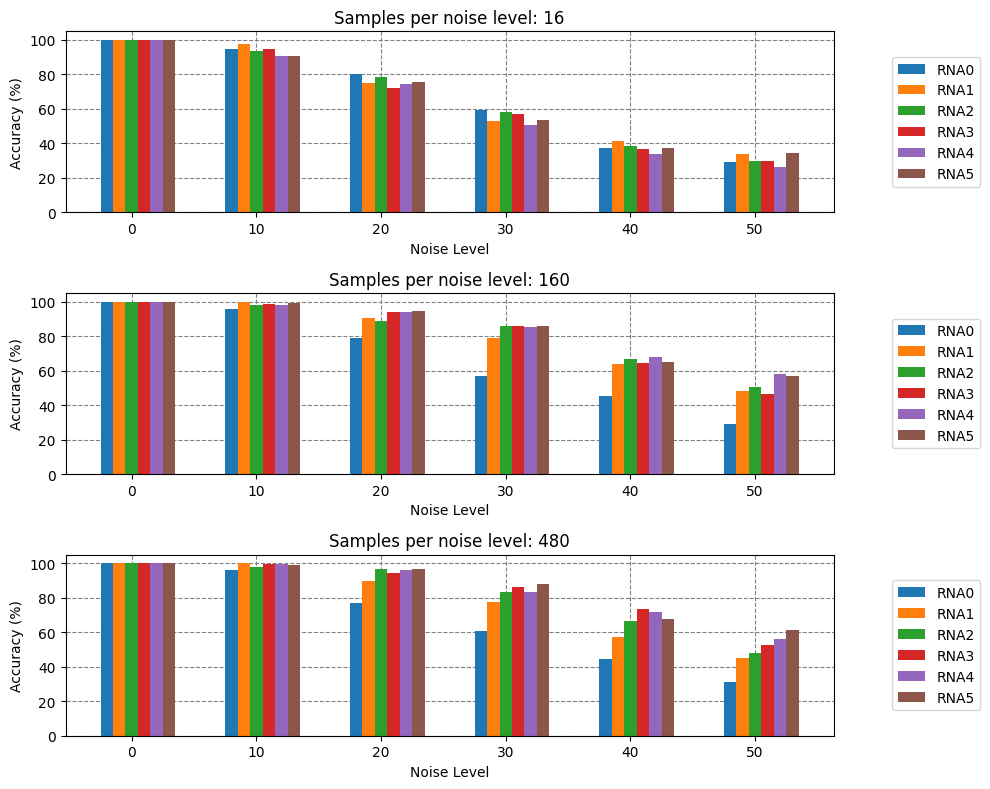

In [7]:
fig, axes = plt.subplots(3,1,figsize=(10,8),tight_layout=True,dpi=100)
x = 10*np.arange(6)
width = 1
for k,num_seeds in enumerate(list_seeds):
    axes[k].set_axisbelow(True)
    axes[k].grid(color='gray', linestyle='dashed')    
    for nn_num,config in enumerate(config_samples_noise):
        y = nns[nn_num][num_seeds]['acc_noise']
        axes[k].bar(x +width*(nn_num-2),y,width = width,label=f'RNA{nn_num}')
        
    axes[k].legend(loc='center right',bbox_to_anchor=(1.2, 0.5))
    axes[k].set_xlabel("Noise Level")
    axes[k].set_ylabel("Accuracy (%)")
    axes[k].set_title(f"Samples per noise level: {16*num_seeds}")

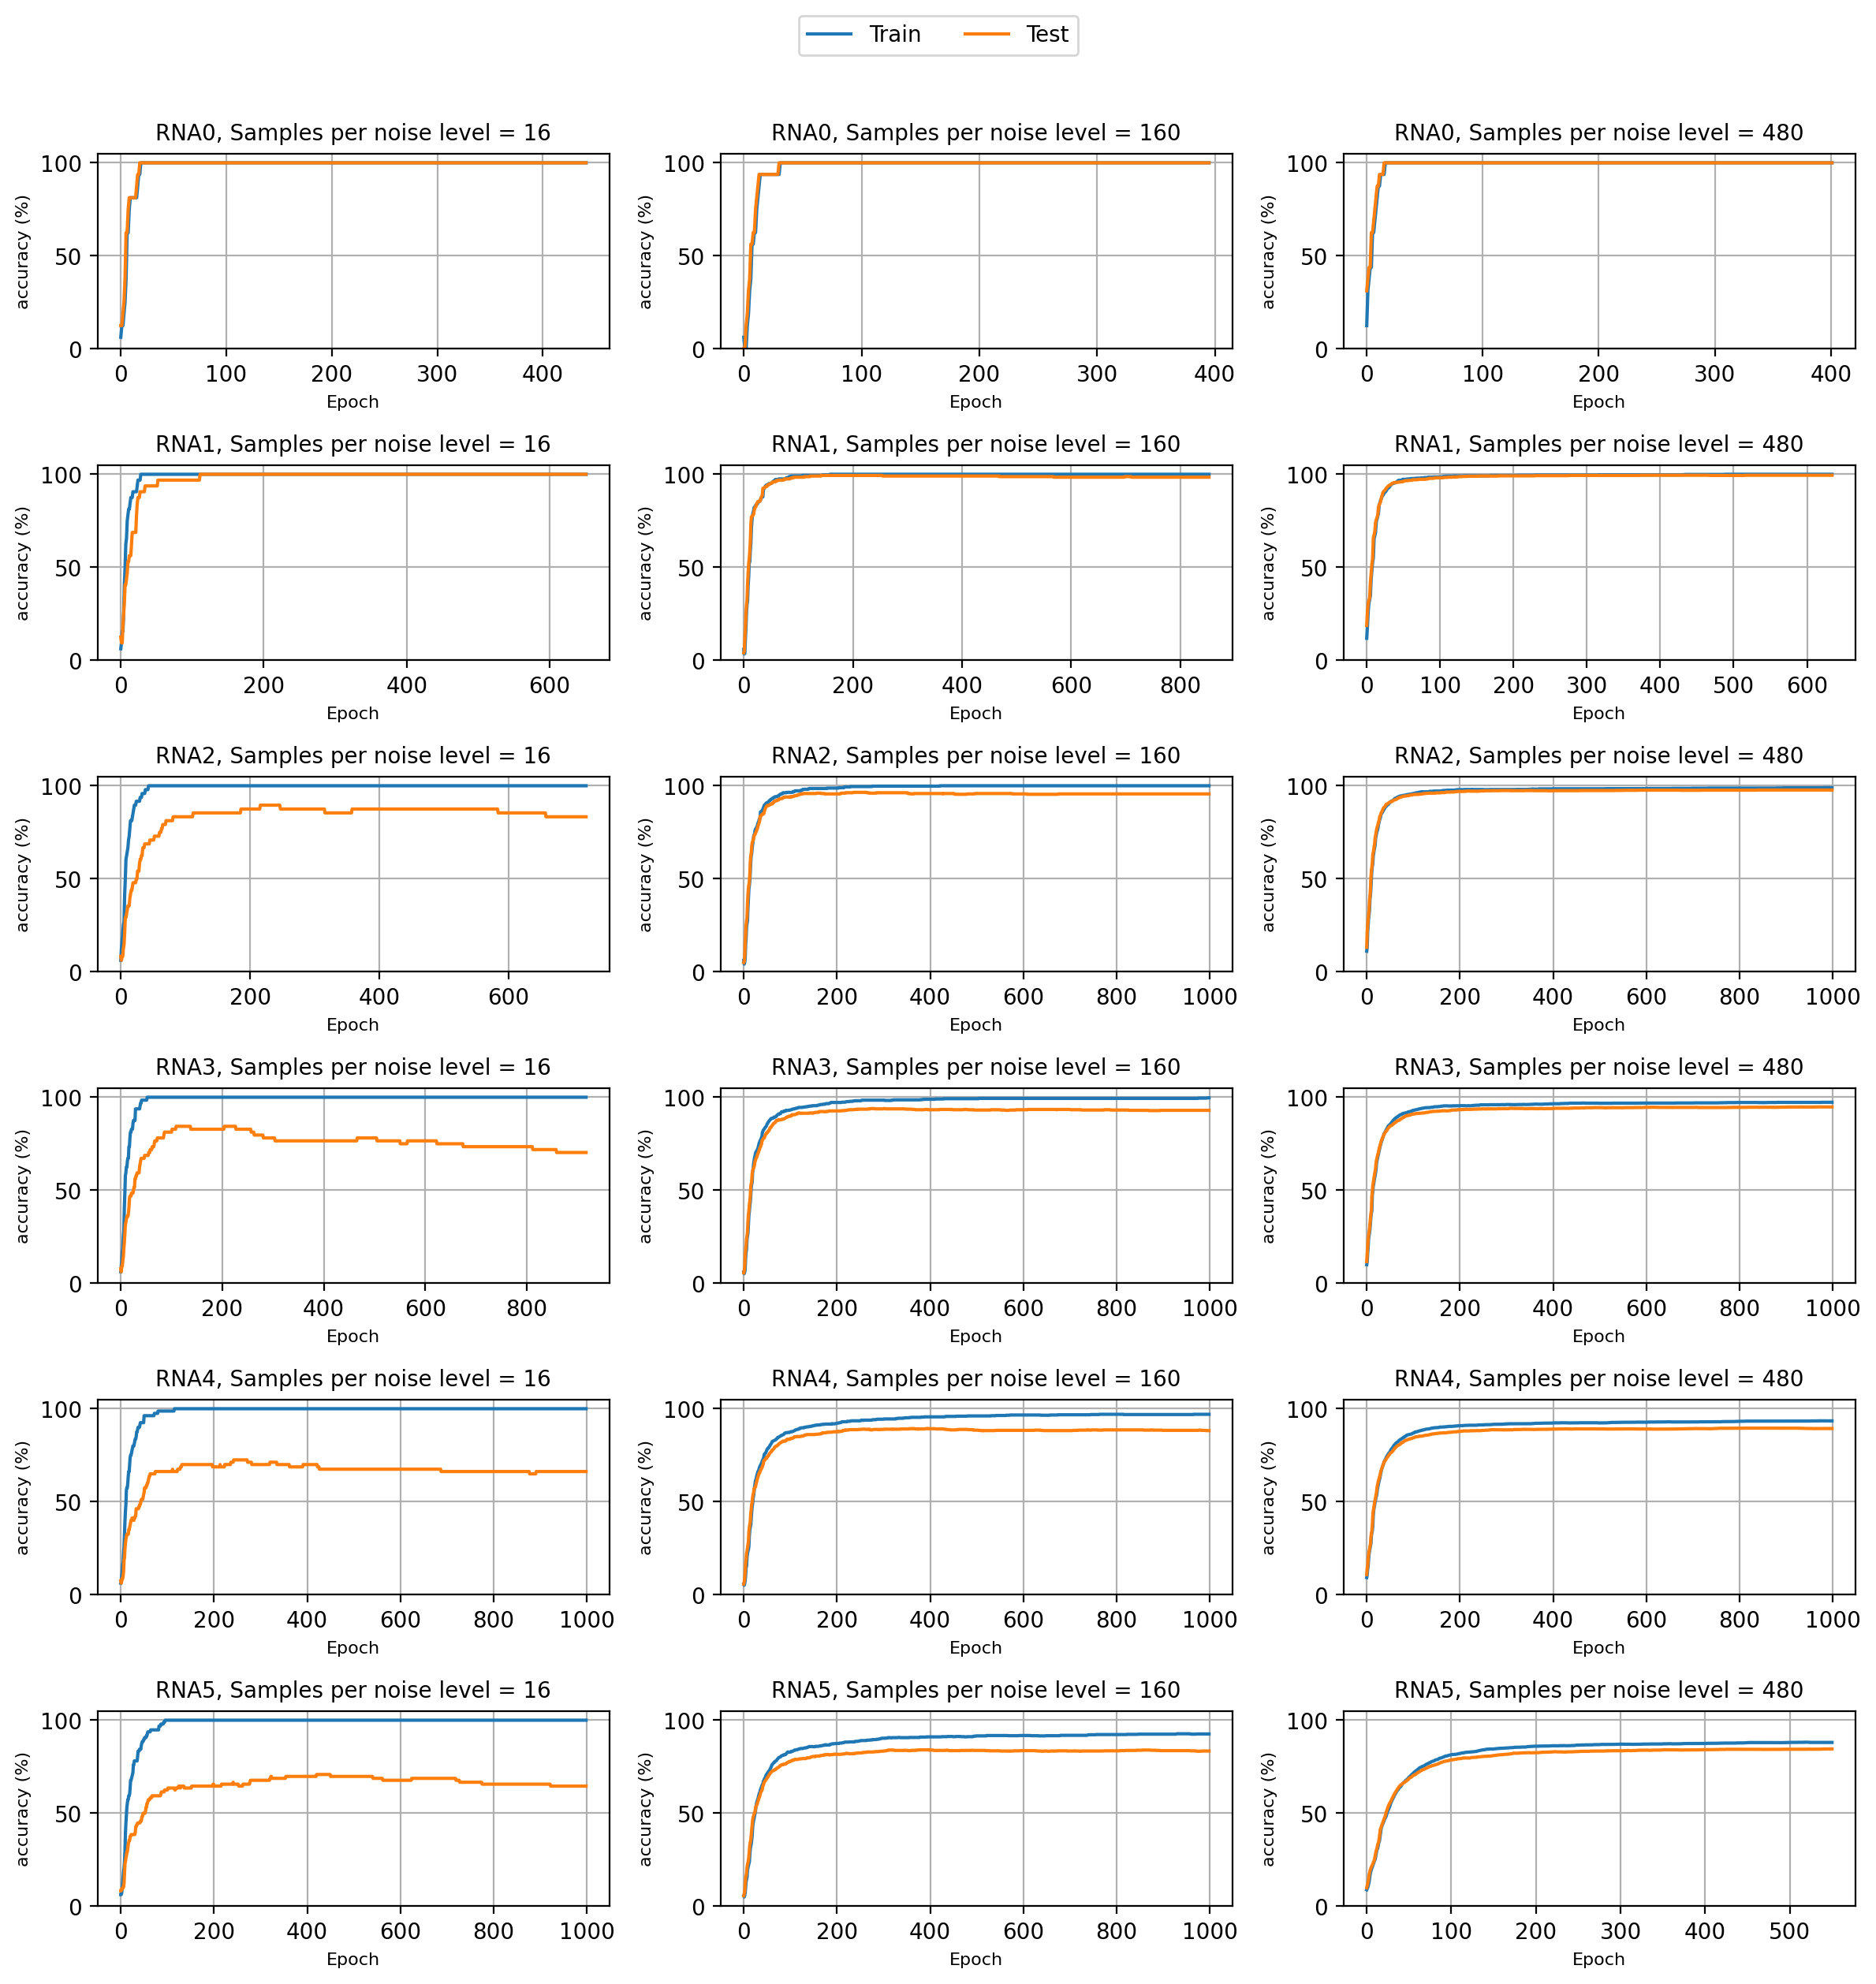

In [8]:
fig,axes = plt.subplots(6,3,figsize=(12,12),tight_layout=True,dpi=200)
for nn_num,config in enumerate(config_samples_noise):
    for k,num_seeds in enumerate(list_seeds):
        train = nns[nn_num][num_seeds]['train_acc_history']
        test = nns[nn_num][num_seeds]['test_acc_history']
        axes[nn_num][k].plot(train,label="Train")
        axes[nn_num][k].plot(test,label="Test")
        axes[nn_num][k].grid()
        axes[nn_num][k].set_xlabel(f"Epoch",fontsize=8)
        axes[nn_num][k].set_ylabel(f"accuracy (%)",fontsize=8)
        axes[nn_num][k].set_title(f"RNA{nn_num}, Samples per noise level = {16 * num_seeds}",fontsize=10)
        axes[nn_num][k].set(ylim=(0, 105))

lines_labels = [axes[nn_num][k].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc="outside upper center",fontsize=10,ncol =2,bbox_to_anchor=(0.5, 1.05));

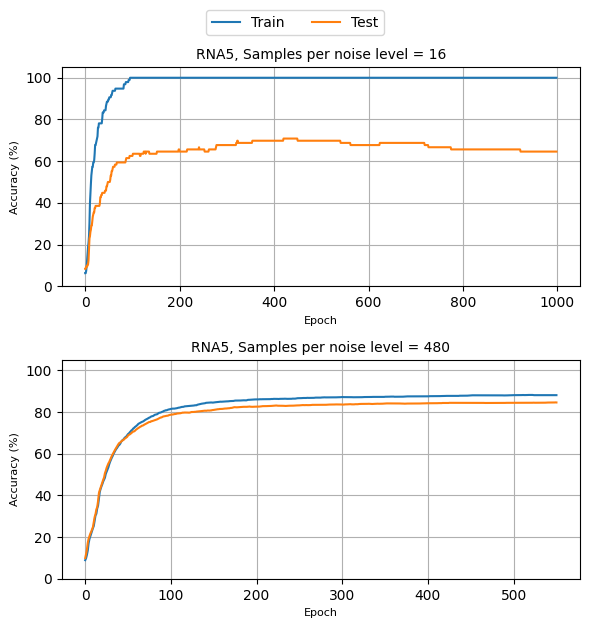

In [9]:
fig,axes = plt.subplots(2,1,figsize=(6,6),tight_layout=True,dpi=100)
for k,num_seeds in enumerate([1,30]):
    train = nns[5][num_seeds]['train_acc_history']
    test = nns[5][num_seeds]['test_acc_history']
    axes[k].plot(train,label="Train")
    axes[k].plot(test,label="Test")
    axes[k].grid()
    axes[k].set_xlabel(f"Epoch",fontsize=8)
    axes[k].set_ylabel(f"Accuracy (%)",fontsize=8)
    axes[k].set_title(f"RNA{5}, Samples per noise level = {16 * num_seeds}",fontsize=10)
    axes[k].set(ylim=(0, 105))

lines_labels = [axes[k].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc="outside upper center",fontsize=10,ncol =2,bbox_to_anchor=(0.5, 1.05));